In [287]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data

import random, os, pathlib, time
from tqdm import tqdm
from sklearn import datasets

In [288]:
device = torch.device("cuda:0")
# device = torch.device("cpu")

## MNIST dataset

In [289]:
import mylibrary.datasets as datasets
import mylibrary.nnlib as tnn

In [290]:
mnist = datasets.FashionMNIST()
# mnist.download_mnist()
# mnist.save_mnist()
train_data, train_label_, test_data, test_label_ = mnist.load()

train_data = train_data / 255.
test_data = test_data / 255.

# train_label = tnn.Logits.index_to_logit(train_label_)
train_size = len(train_label_)

In [291]:
## converting data to pytorch format
train_data = torch.Tensor(train_data)
test_data = torch.Tensor(test_data)
train_label = torch.LongTensor(train_label_)
test_label = torch.LongTensor(test_label_)

In [292]:
input_size = 784
output_size = 10

In [293]:
class MNIST_Dataset(data.Dataset):
    
    def __init__(self, data, label):
        self.data = data
        self.label = label
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
#         print(idx)
        img, lbl = self.data[idx], self.label[idx]
        return img, lbl

In [294]:
train_dataset = MNIST_Dataset(train_data, train_label)
test_dataset = MNIST_Dataset(test_data, test_label)

In [295]:
batch_size = 50
train_loader = data.DataLoader(dataset=train_dataset,
                                    num_workers=4, 
                                    batch_size=batch_size, 
                                    shuffle=True)

test_loader = data.DataLoader(dataset=test_dataset,
                                    num_workers=1, 
                                    batch_size=batch_size, 
                                    shuffle=False)

In [296]:
class DistanceTransform(nn.Module):
    
    def __init__(self, input_dim, num_centers, p=2):
        super().__init__()
        self.input_dim = input_dim
        self.num_centers = num_centers
        self.p = p
        
        self.centers = torch.randn(num_centers, input_dim)/3.
#         self.centers = torch.rand(num_centers, input_dim)
        self.centers = nn.Parameter(self.centers)
        self.inv_params = None
    
    def forward(self, x):
        dists = torch.cdist(x, self.centers, p=self.p)
        
        ### normalize similar to UMAP
#         dists = dists-dists.min(dim=1, keepdim=True)[0]
#         dists = dists-dists.mean(dim=1, keepdim=True)
#         dists = dists/dists.std(dim=1, keepdim=True)

        return dists
    
    def set_centroid_to_data_randomly(self, data_loader):
        indices = np.random.permutation(len(data_loader.dataset.data))[:self.centers.shape[0]]
        self.centers.data = data_loader.dataset.data[indices].to(self.centers.device)
        self.centers.data += torch.randn_like(self.centers)*0.01
        pass
    
    def set_centroid_to_data_maxdist(self, data_loader):
        ## sample N points
        N = self.centers.shape[0]
        new_center = torch.empty_like(self.centers)
        min_dists = torch.empty(N)
        count = 0
        for i, (xx, _) in enumerate(tqdm(data_loader)):
            if count < N:
                if N-count < batch_size:
                    #### final fillup
                    new_center[count:count+N-count] = xx[:N-count]
                    xx = xx[N-count:]
                    dists = torch.cdist(new_center, new_center)+torch.eye(N)*1e5
                    min_dists = dists.min(dim=0)[0]
                    count = N

                else:#### fill the center
                    new_center[count:count+len(xx)] = xx
                    count += len(xx)
                    continue

            ammd = min_dists.argmin()
            for i, x in enumerate(xx):
                dists = torch.norm(new_center-x, dim=1)
                md = dists.min()
                if md > min_dists[ammd]:
                    min_dists[ammd] = md
                    new_center[ammd] = x
                    ammd = min_dists.argmin()
        self.centers.data = new_center.to(self.centers.device)
        pass
        
    
    def set_centroid_to_data(self, data_loader):
        new_center = self.centers.data.clone()
        min_dists = torch.ones(self.centers.shape[0])*1e9

        for xx, _ in data_loader:

            dists = torch.cdist(xx, self.centers.data)
            ### min dist of each center to the data points
            min_d, arg_md = dists.min(dim=0)

            ### dont allow same point to be assigned as closest to multiple centroid
            occupied = []
            for i in np.random.permutation(len(arg_md)):
        #     for i, ind in enumerate(arg_md):
                ind = arg_md[i]
                if ind in occupied:
                    min_d[i] = min_dists[i]
                    arg_md[i] = -1
                else:
                    occupied.append(ind)

            ### the index of centroids that have new min_dist
            idx = torch.nonzero(min_d<min_dists).reshape(-1)

            ### assign new_center to the nearest data point
            new_center[idx] = xx[arg_md[idx]]
            min_dists[idx] = min_d[idx]
            
        self.centers.data = new_center.to(self.centers.device)
        pass
    
    def compute_inverse_matrix(self):
#         A = 2*(self.centers.data[1:]-self.centers.data[:-1])
        A = 2*(self.centers[1:]-self.centers[:-1])
        
#         c2 = self.centers.data**2
        c2 = self.centers**2
        Z = (c2[:-1]-c2[1:]).sum(dim=1, keepdim=True)
        
        invA = torch.pinverse(A)
        self.inv_params = (invA, Z)
        
    def inverse(self, dists):
        assert self.inv_params is not None
        
        d2 = dists**2
        D = d2[:, :-1]-d2[:, 1:]

        invA, Z = self.inv_params
        xrec = torch.matmul(invA, D.t()-Z).t()
        return xrec

In [297]:
class EMA(object):

    def __init__(self, momentum=0.1, mu=None):
        self.mu = mu
        self.momentum = momentum

    def __call__(self, x):
        if self.mu is None:
            self.mu = x
        self.mu = self.momentum*self.mu + (1.0 - self.momentum)*x
        return self.mu

## Inverse function programming

In [298]:
indices = np.random.permutation(len(test_loader.dataset.data))[:50]
xx, yy = test_loader.dataset[indices]

In [299]:
xx

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [300]:
dt = DistanceTransform(784, 100, p=2)
dt.set_centroid_to_data_randomly(train_loader)
dt.centers.data += torch.randn_like(dt.centers)*0.01
# dt.set_centroid_to_data_maxdist(train_loader)
dt.to(device)

DistanceTransform()

In [301]:
dists = dt(xx.to(device))

In [302]:
dt.compute_inverse_matrix()

In [303]:
dt.inv_params

(tensor([[ 1.6172e-03,  1.8433e-03,  3.6585e-03,  ..., -5.4605e-05,
          -1.1281e-03,  4.8149e-04],
         [-7.0240e-04, -6.9918e-04, -2.0896e-03,  ..., -1.9525e-03,
          -1.7577e-03, -1.6056e-03],
         [ 2.7215e-04, -7.0584e-04, -1.6366e-03,  ..., -5.6042e-04,
          -8.5171e-05, -7.6707e-05],
         ...,
         [ 2.0279e-04,  8.6229e-04, -1.7083e-04,  ...,  2.6042e-04,
           1.0606e-04,  8.2474e-04],
         [ 8.5380e-04,  6.4845e-04,  1.3383e-03,  ...,  8.4103e-05,
           4.3272e-04,  8.1928e-04],
         [-9.1225e-04,  2.3630e-04, -1.9600e-03,  ..., -6.9129e-04,
          -1.1428e-03, -1.4315e-03]], device='cuda:0', grad_fn=<MmBackward>),
 tensor([[ 202.4381],
         [ -72.4969],
         [-121.8338],
         [ -54.4008],
         [ -38.3149],
         [ 196.9825],
         [  26.9325],
         [  -1.2158],
         [ -10.9724],
         [-120.9934],
         [ -25.6283],
         [ 200.1507],
         [ -19.4928],
         [-188.1553],
       

In [304]:
xrec = dt.inverse(dists)

In [305]:
iclose = torch.isclose(xrec.data.cpu(), xx, atol=1e-3)
iclose

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ...,  True, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])

In [306]:
print("Not close", torch.numel(xx)-torch.count_nonzero(iclose))

Not close tensor(38682)


In [307]:
i=2

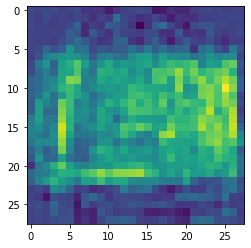

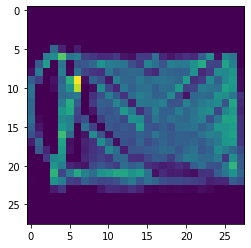

In [308]:
plt.imshow(xrec.data[i].cpu().reshape(28,28))
plt.show()
plt.imshow(xx.data[i].cpu().reshape(28,28))
plt.show()
i+=1

## Train to reduce reconstruction error

In [312]:
dt = DistanceTransform(784, 100)

# dt.set_centroid_to_data_randomly(train_loader)
dt.centers.data += torch.randn_like(dt.centers)*0.01
dt.to(device)

DistanceTransform()

In [313]:
indices = np.random.permutation(len(test_loader.dataset.data))[:50]
xx_, _ = test_loader.dataset[indices]

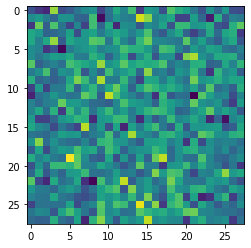

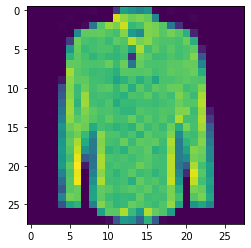

In [314]:
dists = dt(xx_.to(device))
dt.compute_inverse_matrix()
xrec_ = dt.inverse(dists)
i=0
plt.imshow(xrec_.data[i].cpu().reshape(28,28))
plt.show()
plt.imshow(xx_.data[i].cpu().reshape(28,28))
plt.show()

In [315]:
optimizer = optim.Adam(list(dt.parameters()), lr=0.1)
criterion = nn.MSELoss()

In [316]:
index = 0
train_error, test_error = [], []
dt.train()
for epoch in tqdm(list(range(30))):
    train_err = 0
    train_count = 0
    
    for xx, yy in train_loader:
        xx, yy = xx.to(device), yy.to(device)
        dists = dt(xx)
        dt.compute_inverse_matrix()
        xrec = dt.inverse(dists)
        
        loss = criterion(xrec, xx)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_err += float(loss)*len(xx)
        train_count += len(xx)

    test_err = 0
    test_count = 0
    for xx, yy in test_loader:
        xx, yy = xx.to(device), yy.to(device)
        with torch.no_grad():
            dists = dt(xx)
            dt.compute_inverse_matrix()
            xrec = dt.inverse(dists)
            loss = criterion(xrec, xx)
            test_err += float(loss)*len(xx)
            test_count += len(xx)
            
    train_error.append(train_err/train_count)
    test_error.append(test_err/test_count)
        
    print(f'Epoch: {epoch}:{index}, Train Error:{train_error[-1]:4f} Test Error:{test_error[-1]:4f}')

  3%|▎         | 1/30 [00:08<03:59,  8.25s/it]

Epoch: 0:0, Train Error:0.009031 Test Error:0.008127


  7%|▋         | 2/30 [00:16<03:50,  8.22s/it]

Epoch: 1:0, Train Error:0.008067 Test Error:0.008001


 10%|█         | 3/30 [00:24<03:41,  8.20s/it]

Epoch: 2:0, Train Error:0.008002 Test Error:0.007980


 13%|█▎        | 4/30 [00:32<03:33,  8.19s/it]

Epoch: 3:0, Train Error:0.007968 Test Error:0.007950


 17%|█▋        | 5/30 [00:41<03:25,  8.21s/it]

Epoch: 4:0, Train Error:0.007943 Test Error:0.007928


 20%|██        | 6/30 [00:49<03:16,  8.19s/it]

Epoch: 5:0, Train Error:0.007921 Test Error:0.007905


 23%|██▎       | 7/30 [00:57<03:08,  8.19s/it]

Epoch: 6:0, Train Error:0.007902 Test Error:0.007883


 27%|██▋       | 8/30 [01:05<03:01,  8.23s/it]

Epoch: 7:0, Train Error:0.007886 Test Error:0.007870


 30%|███       | 9/30 [01:13<02:53,  8.25s/it]

Epoch: 8:0, Train Error:0.007873 Test Error:0.007864


 30%|███       | 9/30 [01:19<03:06,  8.87s/it]


KeyboardInterrupt: 

In [317]:
### With backprop in inv function
#Epoch: 29:0, Train Error:0.007772 Test Error:0.007768

### Without
# VV bad

In [318]:
dists = dt(xx_.to(device))
dt.compute_inverse_matrix()
xrec_2 = dt.inverse(dists)
i=0

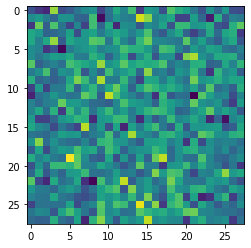

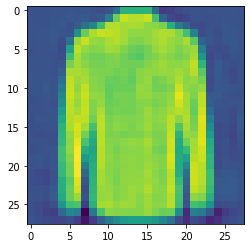

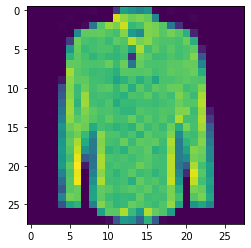

In [319]:
plt.imshow(xrec_.data[i].cpu().reshape(28,28))
plt.show()
plt.imshow(xrec_2.data[i].cpu().reshape(28,28))
plt.show()
plt.imshow(xx_.data[i].cpu().reshape(28,28))
plt.show(); i+=1

### Train linear autoencoder for comparision

In [324]:
class LinearAE(nn.Module):
    
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.enc = nn.Linear(input_dim, hidden_dim)
        self.bias = nn.Parameter(torch.zeros(input_dim))
        
    def forward(self, x):
        h = self.enc(x)
#         w = self.enc.weight
        w = torch.pinverse(self.enc.weight.t())

        xrec = torch.matmul(h, w) + self.bias
        return xrec

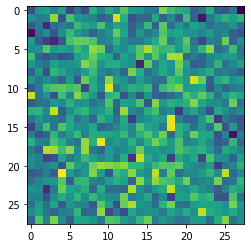

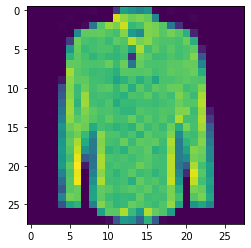

In [325]:
lae = LinearAE(784, 100).to(device)

xrec_ = lae(xx_.to(device)); i=0
plt.imshow(xrec_.data[i].cpu().reshape(28,28))
plt.show()
plt.imshow(xx_.data[i].cpu().reshape(28,28))
plt.show()

In [326]:
optimizer = optim.Adam(list(lae.parameters()), lr=0.001)
criterion = nn.MSELoss()

In [327]:
index = 0
train_error, test_error = [], []
lae.train()
for epoch in tqdm(list(range(30))):
    train_err = 0
    train_count = 0
    
    for xx, yy in train_loader:
        xx, yy = xx.to(device), yy.to(device)
        xrec = lae(xx)
        
        loss = criterion(xrec, xx)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_err += float(loss)*len(xx)
        train_count += len(xx)

    test_err = 0
    test_count = 0
    for xx, yy in test_loader:
        xx, yy = xx.to(device), yy.to(device)
        with torch.no_grad():
            xrec = lae(xx)
            loss = criterion(xrec, xx)
            test_err += float(loss)*len(xx)
            test_count += len(xx)
            
    train_error.append(train_err/train_count)
    test_error.append(test_err/test_count)
        
    print(f'Epoch: {epoch}:{index}, Train Error:{train_error[-1]:4f} Test Error:{test_error[-1]:4f}')

  3%|▎         | 1/30 [00:07<03:51,  7.97s/it]

Epoch: 0:0, Train Error:0.010904 Test Error:0.008084


  7%|▋         | 2/30 [00:15<03:42,  7.95s/it]

Epoch: 1:0, Train Error:0.007972 Test Error:0.007924


 10%|█         | 3/30 [00:23<03:35,  7.97s/it]

Epoch: 2:0, Train Error:0.007902 Test Error:0.007890


 13%|█▎        | 4/30 [00:31<03:26,  7.95s/it]

Epoch: 3:0, Train Error:0.007872 Test Error:0.007861


 17%|█▋        | 5/30 [00:39<03:18,  7.94s/it]

Epoch: 4:0, Train Error:0.007853 Test Error:0.007841


 20%|██        | 6/30 [00:47<03:10,  7.94s/it]

Epoch: 5:0, Train Error:0.007835 Test Error:0.007827


 23%|██▎       | 7/30 [00:55<03:02,  7.96s/it]

Epoch: 6:0, Train Error:0.007821 Test Error:0.007811


 27%|██▋       | 8/30 [01:03<02:55,  7.96s/it]

Epoch: 7:0, Train Error:0.007809 Test Error:0.007797


 30%|███       | 9/30 [01:11<02:47,  7.97s/it]

Epoch: 8:0, Train Error:0.007800 Test Error:0.007791


 33%|███▎      | 10/30 [01:19<02:39,  7.98s/it]

Epoch: 9:0, Train Error:0.007791 Test Error:0.007784


 37%|███▋      | 11/30 [01:27<02:31,  7.98s/it]

Epoch: 10:0, Train Error:0.007782 Test Error:0.007782


 40%|████      | 12/30 [01:35<02:23,  7.98s/it]

Epoch: 11:0, Train Error:0.007776 Test Error:0.007767


 43%|████▎     | 13/30 [01:43<02:15,  7.99s/it]

Epoch: 12:0, Train Error:0.007770 Test Error:0.007766


 43%|████▎     | 13/30 [01:47<02:20,  8.25s/it]


KeyboardInterrupt: 

In [328]:
xrec_3 = lae(xx_.to(device))
i=0

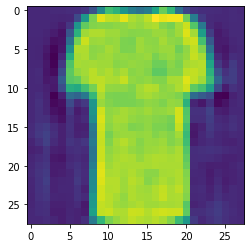

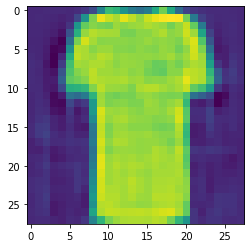

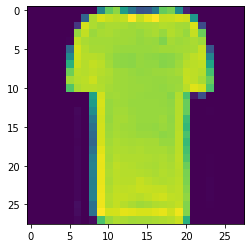

In [340]:
plt.imshow(xrec_2.data[i].cpu().reshape(28,28))
plt.show()
plt.imshow(xrec_3.data[i].cpu().reshape(28,28))
plt.show()
plt.imshow(xx_.data[i].cpu().reshape(28,28))
plt.show(); i+=1